Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import seaborn as sns
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve
from sklearn import preprocessing # Import label encoder 
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm

pd.set_option('display.max_rows', 300) # specifies number of rows to show
pd.options.display.float_format = '{:40,.4f}'.format # specifies default number format to 4 decimal places
plt.style.use('ggplot') # specifies that graphs should use ggplot styling
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

**Jumping to final merged data -FIRMS and ACLED data**


In [3]:
#merged_fire_acled = pd.read_csv("acled_fire_combined_2004_2024.csv", encoding = "latin1")

In [4]:
filtered_acled_fire_2004_24 = pd.read_csv("Acled_Firms_fire_count_year_2004_2024.csv",encoding = "latin1")

In [22]:
filtered_acled_fire_2004_24.head()

,grid_id,year,fireCount,acled_count,geo_fire,geo_acled
0,"48,28",2004,9,0,"{""geodesic"":false,""crs"":{""type"":""name"",""proper...","{""geodesic"":false,""crs"":{""type"":""name"",""proper..."
1,"48,29",2004,4,2,"{""geodesic"":false,""crs"":{""type"":""name"",""proper...","{""geodesic"":false,""crs"":{""type"":""name"",""proper..."
2,"49,27",2004,7,0,"{""geodesic"":false,""crs"":{""type"":""name"",""proper...","{""geodesic"":false,""crs"":{""type"":""name"",""proper..."
3,"49,28",2004,12,0,"{""geodesic"":false,""crs"":{""type"":""name"",""proper...","{""geodesic"":false,""crs"":{""type"":""name"",""proper..."
4,"49,29",2004,10,44,"{""geodesic"":false,""crs"":{""type"":""name"",""proper...","{""geodesic"":false,""crs"":{""type"":""name"",""proper..."


In [23]:
filtered_acled_fire_2004_24.grid_id.count()

17850

In [24]:
#filtered_acled_fire_2004_24[filtered_acled_fire_2004_24['grid_id'] == '49,29']

In [25]:
# Assuming your dataframe is called 'df'
unique_grid_ids = filtered_acled_fire_2004_24['grid_id'].nunique()

print(f"Number of unique grid_id values: {unique_grid_ids}")

Number of unique grid_id values: 850


In [26]:
# Find grid_id with maximum fire count
max_fire_grid = filtered_acled_fire_2004_24.loc[filtered_acled_fire_2004_24['fireCount'].idxmax(), 'grid_id']
max_fire_count = filtered_acled_fire_2004_24['fireCount'].max()

print(f"Grid ID with maximum fire count: {max_fire_grid}")
print(f"Maximum fire count: {max_fire_count}")

Grid ID with maximum fire count: 79,29
Maximum fire count: 44


In [27]:
# Find grid_id with maximum acled count
max_acled_grid = filtered_acled_fire_2004_24.loc[filtered_acled_fire_2004_24['acled_count'].idxmax(), 'grid_id']
max_acled_count = filtered_acled_fire_2004_24['acled_count'].max()

print(f"Grid ID with maximum acled count: {max_acled_grid}")
print(f"Maximum acled count: {max_acled_count}")

Grid ID with maximum acled count: 72,34
Maximum acled count: 4674


In [28]:
# merged_fire_acled

In [29]:
# #Counting Null values by Column
# merged_fire_acled.isnull().sum(axis=0).sort_values(ascending=False)[:12]

In [30]:
# #Counting Null values by Rows
# merged_fire_acled.isnull().sum(axis=1).sort_values(ascending=False).head(20)

In [31]:
filtered_acled_fire_2004_24.isnull().sum(axis=0).sort_values(ascending=False)[:12]

grid_id        0
year           0
fireCount      0
acled_count    0
geo_fire       0
geo_acled      0
dtype: int64

In [32]:
#Counting Null values by Rows
filtered_acled_fire_2004_24.isnull().sum(axis=1).sort_values(ascending=False).head(20)

0        0
11897    0
11903    0
11902    0
11901    0
11900    0
11899    0
11898    0
11896    0
11888    0
11895    0
11894    0
11893    0
11892    0
11891    0
11890    0
11904    0
11905    0
11906    0
11907    0
dtype: int64

In [33]:
import json
# Converting the JSON strings to dictionaries for proper comparison
filtered_acled_fire_2004_24['geo_acled'] = filtered_acled_fire_2004_24['geo_acled'].apply(json.loads)
filtered_acled_fire_2004_24['geo_fire'] = filtered_acled_fire_2004_24['geo_fire'].apply(json.loads)

# Checking if the geo_acled and geo_fire columns are the same
filtered_acled_fire_2004_24['geo_equal'] = filtered_acled_fire_2004_24['geo_acled'] == filtered_acled_fire_2004_24['geo_fire']



In [34]:
# # Display the DataFrame with the comparison result
print(filtered_acled_fire_2004_24)

      grid_id  year  fireCount  acled_count  \
0       48,28  2004          9            0   
1       48,29  2004          4            2   
2       49,27  2004          7            0   
3       49,28  2004         12            0   
4       49,29  2004         10           44   
...       ...   ...        ...          ...   
17845   84,41  2024          2            0   
17846   84,42  2024          0            0   
17847   85,39  2024          0            0   
17848   85,40  2024          0            0   
17849   85,41  2024          1            0   

                                                geo_fire  \
0      {'geodesic': False, 'crs': {'type': 'name', 'p...   
1      {'geodesic': False, 'crs': {'type': 'name', 'p...   
2      {'geodesic': False, 'crs': {'type': 'name', 'p...   
3      {'geodesic': False, 'crs': {'type': 'name', 'p...   
4      {'geodesic': False, 'crs': {'type': 'name', 'p...   
...                                                  ...   
17845  {'geodes

In [35]:
#filtered_acled_fire_2004_24

In [36]:
from shapely.geometry import shape

# If all geo_equal are True, use geo_acled for creating GeoDataFrame
if filtered_acled_fire_2004_24['geo_equal'].all():
    # Convert the 'geo_acled' column to shapely geometries
    filtered_acled_fire_2004_24['geometry'] = filtered_acled_fire_2004_24['geo_acled'].apply(lambda x: shape(x))

    # Create a GeoDataFrame
    gdf_new = gpd.GeoDataFrame(filtered_acled_fire_2004_24, geometry='geometry')

    print(gdf_new)  # Display the GeoDataFrame
else:
    print("The geo_acled and geo_fire columns are not all the same.")    
    

      grid_id  year  fireCount  acled_count  \
0       48,28  2004          9            0   
1       48,29  2004          4            2   
2       49,27  2004          7            0   
3       49,28  2004         12            0   
4       49,29  2004         10           44   
...       ...   ...        ...          ...   
17845   84,41  2024          2            0   
17846   84,42  2024          0            0   
17847   85,39  2024          0            0   
17848   85,40  2024          0            0   
17849   85,41  2024          1            0   

                                                geo_fire  \
0      {'geodesic': False, 'crs': {'type': 'name', 'p...   
1      {'geodesic': False, 'crs': {'type': 'name', 'p...   
2      {'geodesic': False, 'crs': {'type': 'name', 'p...   
3      {'geodesic': False, 'crs': {'type': 'name', 'p...   
4      {'geodesic': False, 'crs': {'type': 'name', 'p...   
...                                                  ...   
17845  {'geodes

In [37]:
gdf_new

,grid_id,year,fireCount,acled_count,geo_fire,geo_acled,geo_equal,geometry
0,"48,28",2004,9,0,"{'geodesic': False, 'crs': {'type': 'name', 'p...","{'geodesic': False, 'crs': {'type': 'name', 'p...",True,"POLYGON ((21.55957 12.57641, 22.00872 12.57641..."
1,"48,29",2004,4,2,"{'geodesic': False, 'crs': {'type': 'name', 'p...","{'geodesic': False, 'crs': {'type': 'name', 'p...",True,"POLYGON ((21.55957 13.02557, 22.00872 13.02557..."
2,"49,27",2004,7,0,"{'geodesic': False, 'crs': {'type': 'name', 'p...","{'geodesic': False, 'crs': {'type': 'name', 'p...",True,"POLYGON ((22.00872 12.12726, 22.45788 12.12726..."
3,"49,28",2004,12,0,"{'geodesic': False, 'crs': {'type': 'name', 'p...","{'geodesic': False, 'crs': {'type': 'name', 'p...",True,"POLYGON ((22.00872 12.57641, 22.45788 12.57641..."
4,"49,29",2004,10,44,"{'geodesic': False, 'crs': {'type': 'name', 'p...","{'geodesic': False, 'crs': {'type': 'name', 'p...",True,"POLYGON ((22.00872 13.02557, 22.45788 13.02557..."
...,...,...,...,...,...,...,...,...
17845,"84,41",2024,2,0,"{'geodesic': False, 'crs': {'type': 'name', 'p...","{'geodesic': False, 'crs': {'type': 'name', 'p...",True,"POLYGON ((37.72924 18.41546, 38.17840 18.41546..."
17846,"84,42",2024,0,0,"{'geodesic': False, 'crs': {'type': 'name', 'p...","{'geodesic': False, 'crs': {'type': 'name', 'p...",True,"POLYGON ((37.72924 18.86462, 38.17840 18.86462..."
17847,"85,39",2024,0,0,"{'geodesic': False, 'crs': {'type': 'name', 'p...","{'geodesic': False, 'crs': {'type': 'name', 'p...",True,"POLYGON ((38.17840 17.51715, 38.62756 17.51715..."
17848,"85,40",2024,0,0,"{'geodesic': False, 'crs': {'type': 'name', 'p...","{'geodesic': False, 'crs': {'type': 'name', 'p...",True,"POLYGON ((38.17840 17.96631, 38.62756 17.96631..."


In [38]:
gdf_new=gdf_new.drop(columns=['geo_acled','geo_fire','geo_equal'])

In [39]:
# # Converting the JSON strings to dictionaries for proper comparison
# merged_fire_acled['geo_acled'] = merged_fire_acled['geo_acled'].apply(json.loads)
# merged_fire_acled['geo_fire'] = merged_fire_acled['geo_fire'].apply(json.loads)

# # Checking if the geo_acled and geo_fire columns are the same
# merged_fire_acled['geo_equal'] = merged_fire_acled['geo_acled'] == merged_fire_acled['geo_fire']

# # Display the DataFrame with the comparison result
# print(merged_fire_acled)

In [40]:
# from shapely.geometry import shape
# # If all geo_equal are True, use geo_acled for creating GeoDataFrame
# if merged_fire_acled['geo_equal'].all():
#     # Convert the 'geo_acled' column to shapely geometries
#     merged_fire_acled['geometry'] = merged_fire_acled['geo_acled'].apply(lambda x: shape(x))

#     # Create a GeoDataFrame
#     gdf = gpd.GeoDataFrame(merged_fire_acled, geometry='geometry')

#     # Display the GeoDataFrame
#     print(gdf)
# else:
#     print("The geo_acled and geo_fire columns are not all the same.")

In [41]:
# gdf

In [42]:
# gdf=gdf.drop(columns=['geo_acled','geo_fire','geo_equal'])

In [45]:
gdf_new.head()

,grid_id,year,fireCount,acled_count,geometry
0,"48,28",2004,9,0,"POLYGON ((21.55957 12.57641, 22.00872 12.57641..."
1,"48,29",2004,4,2,"POLYGON ((21.55957 13.02557, 22.00872 13.02557..."
2,"49,27",2004,7,0,"POLYGON ((22.00872 12.12726, 22.45788 12.12726..."
3,"49,28",2004,12,0,"POLYGON ((22.00872 12.57641, 22.45788 12.57641..."
4,"49,29",2004,10,44,"POLYGON ((22.00872 13.02557, 22.45788 13.02557..."


In [44]:
gdf_new.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 17850 entries, 0 to 17849
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   grid_id      17850 non-null  object  
 1   year         17850 non-null  int64   
 2   fireCount    17850 non-null  int64   
 3   acled_count  17850 non-null  int64   
 4   geometry     17850 non-null  geometry
dtypes: geometry(1), int64(3), object(1)
memory usage: 697.4+ KB


# Map Plot, Zero Fire Count Drop

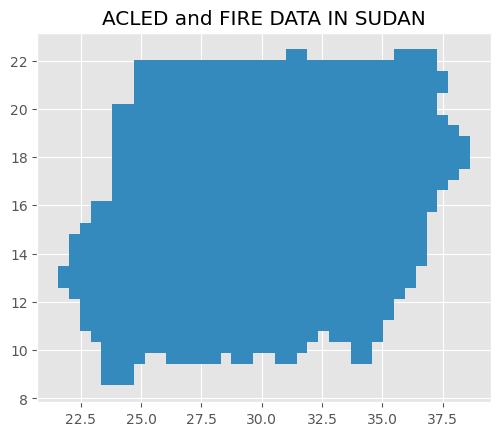

In [91]:
#Plotting the data
gdf_new.plot()
plt.title('ACLED and FIRE DATA IN SUDAN')
plt.show()

In [92]:
print(gdf_new.crs)

None


**Setting the CRS**

In [93]:
gdf_new.set_crs(epsg=4326, inplace=True)

,grid_id,year,fireCount,acled_count,geometry
0,"48,28",2004,9,0,"POLYGON ((21.55957 12.57641, 22.00872 12.57641..."
1,"48,29",2004,4,2,"POLYGON ((21.55957 13.02557, 22.00872 13.02557..."
2,"49,27",2004,7,0,"POLYGON ((22.00872 12.12726, 22.45788 12.12726..."
3,"49,28",2004,12,0,"POLYGON ((22.00872 12.57641, 22.45788 12.57641..."
4,"49,29",2004,10,44,"POLYGON ((22.00872 13.02557, 22.45788 13.02557..."
...,...,...,...,...,...
17845,"84,41",2024,2,0,"POLYGON ((37.72924 18.41546, 38.17840 18.41546..."
17846,"84,42",2024,0,0,"POLYGON ((37.72924 18.86462, 38.17840 18.86462..."
17847,"85,39",2024,0,0,"POLYGON ((38.17840 17.51715, 38.62756 17.51715..."
17848,"85,40",2024,0,0,"POLYGON ((38.17840 17.96631, 38.62756 17.96631..."


The CRS is set to EPSG 4326.

In [94]:
print(gdf_new.crs)

EPSG:4326


**Making Two separate interactive Maps for FIRMS and ACLED**

In [104]:
gdf_new.describe()

,year,fireCount,acled_count
count,"17,850.0000","17,850.0000","17,850.0000"
mean,"2,014.0000",3.3295,1.6683
std,6.0555,6.2425,38.8632
min,"2,004.0000",0.0000,0.0000
25%,"2,009.0000",0.0000,0.0000
50%,"2,014.0000",0.0000,0.0000
75%,"2,019.0000",4.0000,0.0000
max,"2,024.0000",44.0000,"4,674.0000"


In [99]:
import folium
from branca.colormap import LinearColormap

# Print the current CRS
print("Current CRS:", gdf_new.crs)

# If CRS is None, set it (replace xxxx with the correct EPSG code)
if gdf_new.crs is None:
    gdf_new.set_crs(epsg=xxxx, inplace=True)
    print("CRS set to:", gdf_new.crs)

# Assuming your geodataframe is named 'gdf'
# Convert the GeoDataFrame to WGS84 coordinate system if it's not already
gdf_new = gdf_new.to_crs(epsg=4326)

# Calculate the center of the map
center_lat = gdf_new.geometry.centroid.y.mean()
center_lon = gdf_new.geometry.centroid.x.mean()

# Function to create a map
def create_map(data, column, title, colors):
    m = folium.Map(location=[center_lat, center_lon], zoom_start=6)
    
    colormap = LinearColormap(colors=colors, vmin=data[column].min(), vmax=data[column].max())
    
    for idx, row in data.iterrows():
        color = colormap(row[column])
        
        folium.GeoJson(
            row['geometry'],
            style_function=lambda x, color=color: {
                'fillColor': color,
                'color': 'grey',
                'weight': 1,
                'fillOpacity': 0.7
            },
            tooltip=f"{title}: {row[column]}"
        ).add_to(m)
    
    colormap.add_to(m)
    m.save(f'{title.lower().replace(" ", "_")}_map_new.html')
    print(f"Interactive {title} map saved as '{title.lower().replace(' ', '_')}_map_new.html'")

# # Create Fire Count Map
create_map(gdf_new, 'fireCount', 'Fire Count', ['yellow', 'orange'])

# Create ACLED Count Map
create_map(gdf_new, 'acled_count', 'ACLED Count', ['yellow', 'green'])

Current CRS: EPSG:4326
Interactive Fire Count map saved as 'fire_count_map_new.html'
Interactive ACLED Count map saved as 'acled_count_map_new.html'


In [100]:
# import folium
# from branca.colormap import LinearColormap

# # Print the current CRS
# print("Current CRS:", gdf.crs)

# # If CRS is None, set it (replace xxxx with the correct EPSG code)
# if gdf.crs is None:
#     gdf.set_crs(epsg=xxxx, inplace=True)
#     print("CRS set to:", gdf.crs)

# # Assuming your geodataframe is named 'gdf'
# # Convert the GeoDataFrame to WGS84 coordinate system if it's not already
# gdf = gdf.to_crs(epsg=4326)

# # Calculate the center of the map
# center_lat = gdf.geometry.centroid.y.mean()
# center_lon = gdf.geometry.centroid.x.mean()

# # Function to create a map
# def create_map(data, column, title, colors):
#     m = folium.Map(location=[center_lat, center_lon], zoom_start=6)
    
#     colormap = LinearColormap(colors=colors, vmin=data[column].min(), vmax=data[column].max())
    
#     for idx, row in data.iterrows():
#         color = colormap(row[column])
        
#         folium.GeoJson(
#             row['geometry'],
#             style_function=lambda x, color=color: {
#                 'fillColor': color,
#                 'color': 'black',
#                 'weight': 1,
#                 'fillOpacity': 0.7
#             },
#             tooltip=f"{title}: {row[column]}"
#         ).add_to(m)
    
#     colormap.add_to(m)
#     m.save(f'{title.lower().replace(" ", "_")}_map.html')
#     print(f"Interactive {title} map saved as '{title.lower().replace(' ', '_')}_map.html'")

# # Create Fire Count Map
# create_map(gdf, 'fireCount', 'Fire Count', ['yellow', 'orange', 'red'])

# # Create ACLED Count Map
# create_map(gdf, 'acled_count', 'ACLED Count', ['lightblue', 'blue', 'darkblue'])

As we can see in the map we got of sudan there are no fires in the Northern part of Country. As it all deserted area most of the fires are at populated areas ---compared to Sudan population.

**Dropping Rows with zero firecount**

In [101]:
gdf_new

,grid_id,year,fireCount,acled_count,geometry
0,"48,28",2004,9,0,"POLYGON ((21.55957 12.57641, 22.00872 12.57641..."
1,"48,29",2004,4,2,"POLYGON ((21.55957 13.02557, 22.00872 13.02557..."
2,"49,27",2004,7,0,"POLYGON ((22.00872 12.12726, 22.45788 12.12726..."
3,"49,28",2004,12,0,"POLYGON ((22.00872 12.57641, 22.45788 12.57641..."
4,"49,29",2004,10,44,"POLYGON ((22.00872 13.02557, 22.45788 13.02557..."
...,...,...,...,...,...
17845,"84,41",2024,2,0,"POLYGON ((37.72924 18.41546, 38.17840 18.41546..."
17846,"84,42",2024,0,0,"POLYGON ((37.72924 18.86462, 38.17840 18.86462..."
17847,"85,39",2024,0,0,"POLYGON ((38.17840 17.51715, 38.62756 17.51715..."
17848,"85,40",2024,0,0,"POLYGON ((38.17840 17.96631, 38.62756 17.96631..."


In [102]:
# Print the original number of rows
print("Original number of rows:", len(gdf_new))

# Filter out rows where fireCount is 0 and create a new GeoDataFrame
gdf_filter1 = gdf_new[gdf_new['fireCount'] > 0].copy()

# Print the number of rows after filtering
print("Number of rows after filtering:", len(gdf_filter1))

# Verify that we still have the necessary columns
print("\nColumns in filtered GeoDataFrame:")
print(gdf_filter1.columns)

Original number of rows: 17850
Number of rows after filtering: 6947

Columns in filtered GeoDataFrame:
Index(['grid_id', 'year', 'fireCount', 'acled_count', 'geometry'], dtype='object')


In [44]:
# Check the data types to ensure geometry is preserved
print("\nData types:")
print(gdf_filter1.dtypes)


Data types:
grid_id          object
year              int64
fireCount         int64
acled_count       int64
geometry       geometry
dtype: object


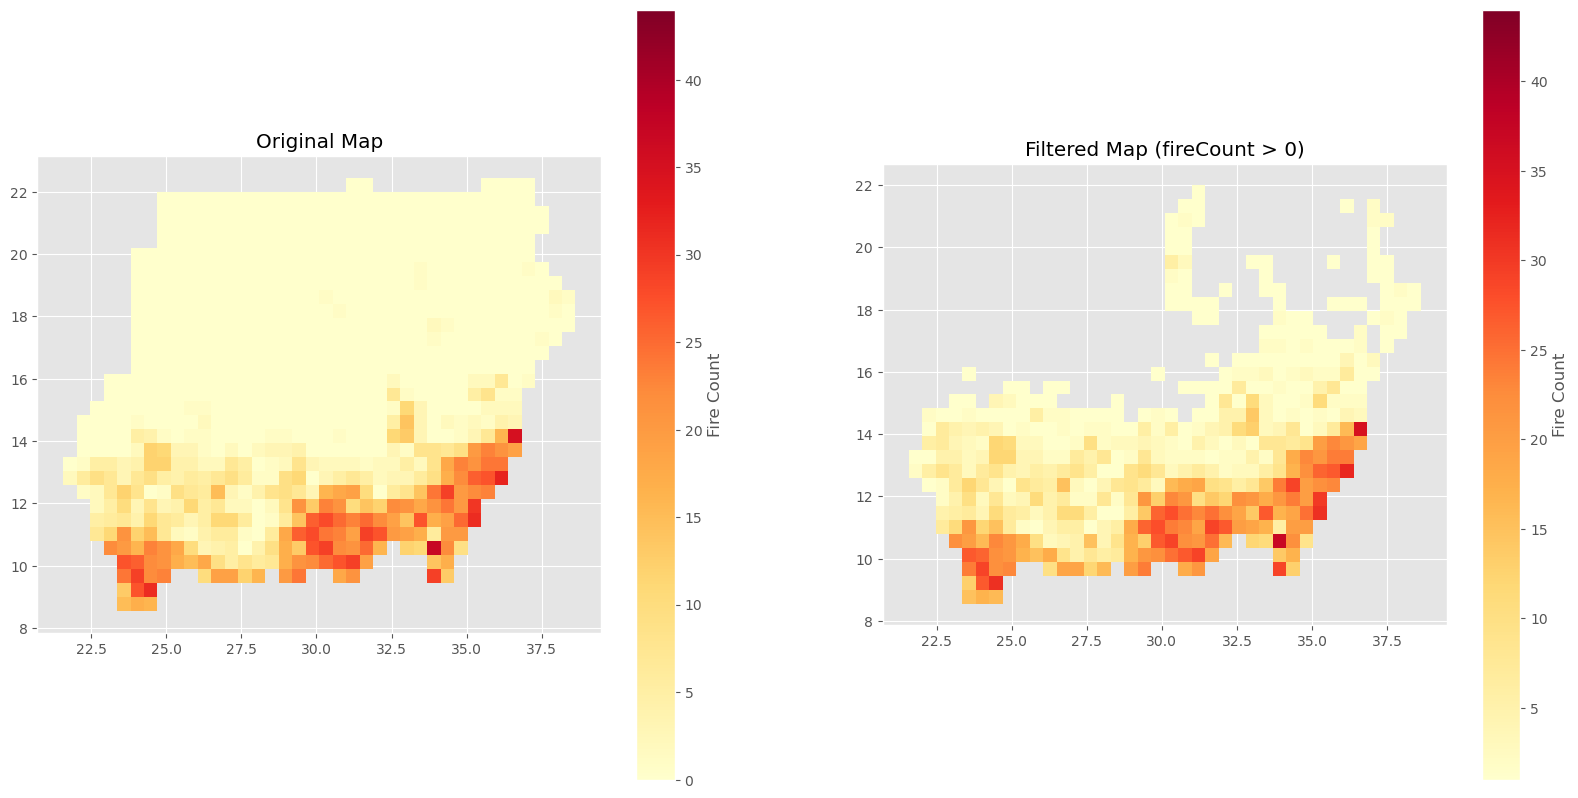


Sample data from filtered GeoDataFrame:
  grid_id  year  fireCount  acled_count  \
0   48,28  2004          9            0   
1   48,29  2004          4            2   
2   49,27  2004          7            0   
3   49,28  2004         12            0   
4   49,29  2004         10           44   

                                            geometry  
0  POLYGON ((21.55957 12.57641, 22.00872 12.57641...  
1  POLYGON ((21.55957 13.02557, 22.00872 13.02557...  
2  POLYGON ((22.00872 12.12726, 22.45788 12.12726...  
3  POLYGON ((22.00872 12.57641, 22.45788 12.57641...  
4  POLYGON ((22.00872 13.02557, 22.45788 13.02557...  


In [45]:
# Plot the original and filtered maps to visually confirm the geometries are preserved
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

gdf_new.plot(ax=ax1, column='fireCount', legend=True, cmap='YlOrRd', legend_kwds={'label': 'Fire Count'})
ax1.set_title('Original Map')

gdf_filter1.plot(ax=ax2, column='fireCount', legend=True, cmap='YlOrRd', legend_kwds={'label': 'Fire Count'})
ax2.set_title('Filtered Map (fireCount > 0)')

plt.show()

# Print some sample data to confirm we have all necessary information
print("\nSample data from filtered GeoDataFrame:")
print(gdf_filter1.head())

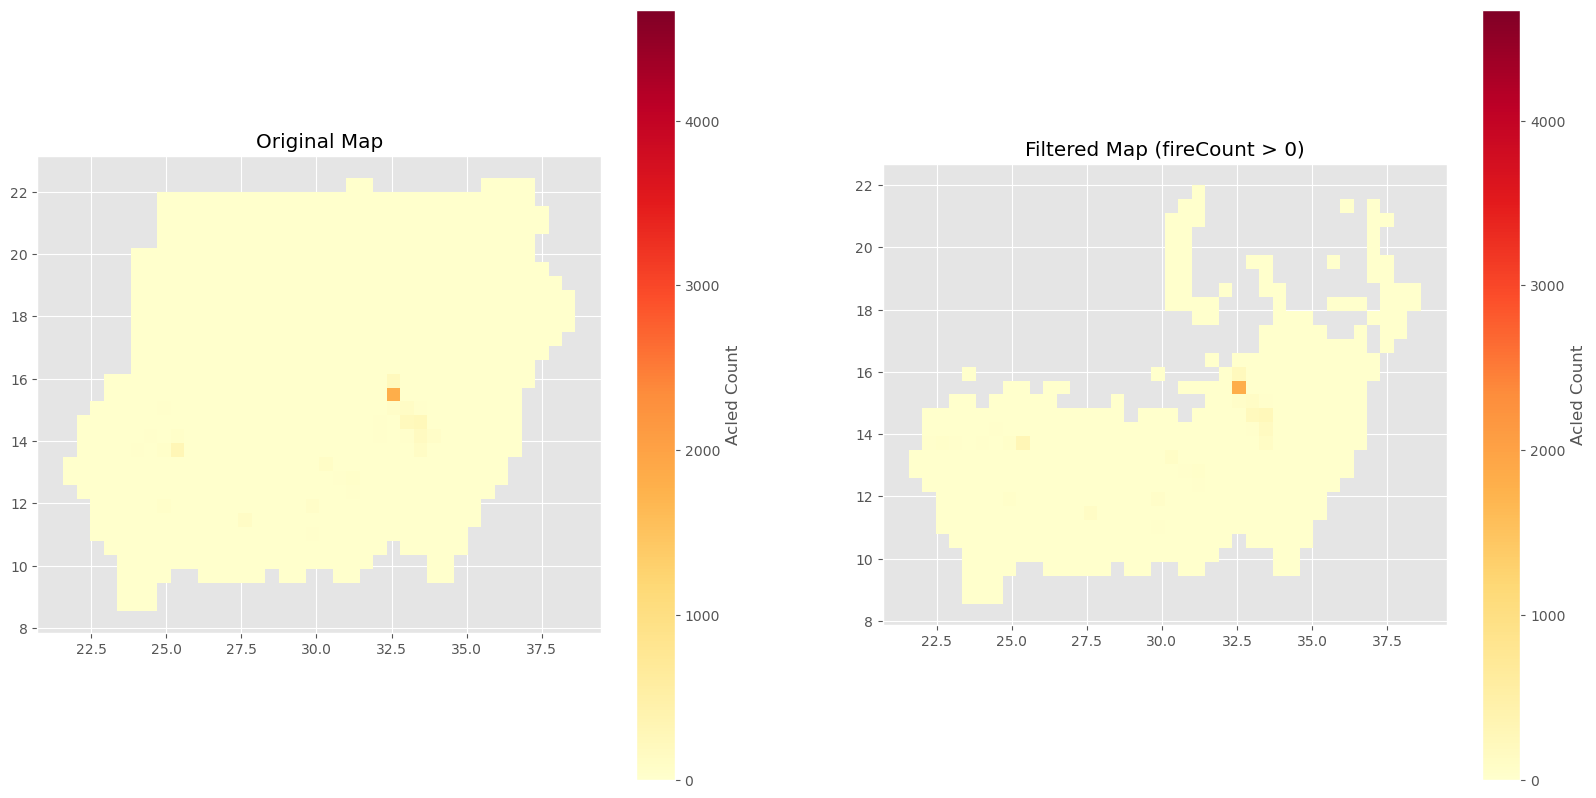


Sample data from filtered GeoDataFrame:
  grid_id  year  fireCount  acled_count  \
0   48,28  2004          9            0   
1   48,29  2004          4            2   
2   49,27  2004          7            0   
3   49,28  2004         12            0   
4   49,29  2004         10           44   

                                            geometry  
0  POLYGON ((21.55957 12.57641, 22.00872 12.57641...  
1  POLYGON ((21.55957 13.02557, 22.00872 13.02557...  
2  POLYGON ((22.00872 12.12726, 22.45788 12.12726...  
3  POLYGON ((22.00872 12.57641, 22.45788 12.57641...  
4  POLYGON ((22.00872 13.02557, 22.45788 13.02557...  


In [103]:
# Plot the original and filtered maps to visually confirm the geometries are preserved
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

gdf_new.plot(ax=ax1, column='acled_count', legend=True, cmap='YlOrRd', legend_kwds={'label': 'Acled Count'})
ax1.set_title('Original Map')

gdf_filter1.plot(ax=ax2, column='acled_count', legend=True, cmap='YlOrRd', legend_kwds={'label': 'Acled Count'})
ax2.set_title('Filtered Map (fireCount > 0)')

plt.show()

# Print some sample data to confirm we have all necessary information
print("\nSample data from filtered GeoDataFrame:")
print(gdf_filter1.head())

In [42]:
# # Print the original number of rows
# print("Original number of rows:", len(gdf))

# # Filter out rows where fireCount is 0 and update the GeoDataFrame
# gdf_filter = gdf[gdf['fireCount'] > 0]

# # Print the number of rows after filtering
# print("Number of rows after filtering:", len(gdf_filter))

Original number of rows: 17850
Number of rows after filtering: 6947


In [47]:
gdf_filter1

,grid_id,year,fireCount,acled_count,geometry
0,"48,28",2004,9,0,"POLYGON ((21.55957 12.57641, 22.00872 12.57641..."
1,"48,29",2004,4,2,"POLYGON ((21.55957 13.02557, 22.00872 13.02557..."
2,"49,27",2004,7,0,"POLYGON ((22.00872 12.12726, 22.45788 12.12726..."
3,"49,28",2004,12,0,"POLYGON ((22.00872 12.57641, 22.45788 12.57641..."
4,"49,29",2004,10,44,"POLYGON ((22.00872 13.02557, 22.45788 13.02557..."
...,...,...,...,...,...
17826,"82,43",2024,1,2,"POLYGON ((36.83093 19.31378, 37.28008 19.31378..."
17834,"83,38",2024,1,0,"POLYGON ((37.28008 17.06799, 37.72924 17.06799..."
17844,"84,40",2024,1,0,"POLYGON ((37.72924 17.96631, 38.17840 17.96631..."
17845,"84,41",2024,2,0,"POLYGON ((37.72924 18.41546, 38.17840 18.41546..."


<Axes: >

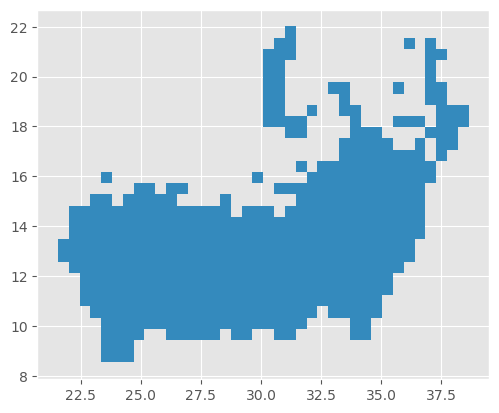

In [48]:
gdf_filter1.plot()

In [49]:
gdf_filter1.describe()

,year,fireCount,acled_count
count,"6,947.0000","6,947.0000","6,947.0000"
mean,"2,014.3682",8.5551,3.7898
std,6.1386,7.4448,62.0878
min,"2,004.0000",1.0000,0.0000
25%,"2,009.0000",2.0000,0.0000
50%,"2,015.0000",6.0000,0.0000
75%,"2,020.0000",13.0000,0.0000
max,"2,024.0000",44.0000,"4,674.0000"


In [56]:
if gdf_filter1.empty:
    print("The GeoDataFrame is empty. Please check your data.")
else:
    # Create the plot
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))

    # Plot the fire counts
    gdf_filter1.plot(column='fireCount', 
             ax=ax, 
             legend=True, 
             legend_kwds={'label': 'Fire Count', 'orientation': 'horizontal'},
             cmap='YlOrRd',
             missing_kwds={'color': 'lightgrey'},
             edgecolor='black',
             linewidth=0.5)

    # Add a title
    plt.title('Fire Counts by Grid', fontsize=16)

    # Remove axes
    ax.axis('off')

    # Set the extent of the plot to the bounds of the data
    ax.set_xlim(gdf_filter1.total_bounds[0], gdf_filter1.total_bounds[2])
    ax.set_ylim(gdf_filter1.total_bounds[1], gdf_filter1.total_bounds[3])

    # Adjust layout and save
    plt.tight_layout()
    plt.savefig('fire_counts_map_without_zero_fire.png', dpi=300, bbox_inches='tight')
    plt.close()
    

    print("Fire counts map saved as 'fire_counts_map_without_zero_fire.png'")
    plt.show()

Fire counts map saved as 'fire_counts_map_without_zero_fire.png'
Number of rows: 6947
Columns: Index(['grid_id', 'year', 'fireCount', 'acled_count', 'geometry'], dtype='object')
CRS: EPSG:4326


AttributeError: 'GeoDataFrame' object has no attribute 'geometry_fire'

In [57]:
# Print some information about the GeoDataFrame
print(f"Number of rows: {len(gdf_filter1)}")
print(f"Columns: {gdf_filter1.columns}")
print(f"CRS: {gdf_filter1.crs}")
print(f"Geometry type: {gdf_filter1.geometry.geom_type.value_counts()}")
print(f"Bounding box: {gdf_filter1.total_bounds}")

Number of rows: 6947
Columns: Index(['grid_id', 'year', 'fireCount', 'acled_count', 'geometry'], dtype='object')
CRS: EPSG:4326
Geometry type: Polygon    6947
Name: count, dtype: int64
Bounding box: [21.55956682  8.5339952  38.62755722 22.00872446]


ACLED counts map saved as 'acled_counts_map_without_zero_fire.png'


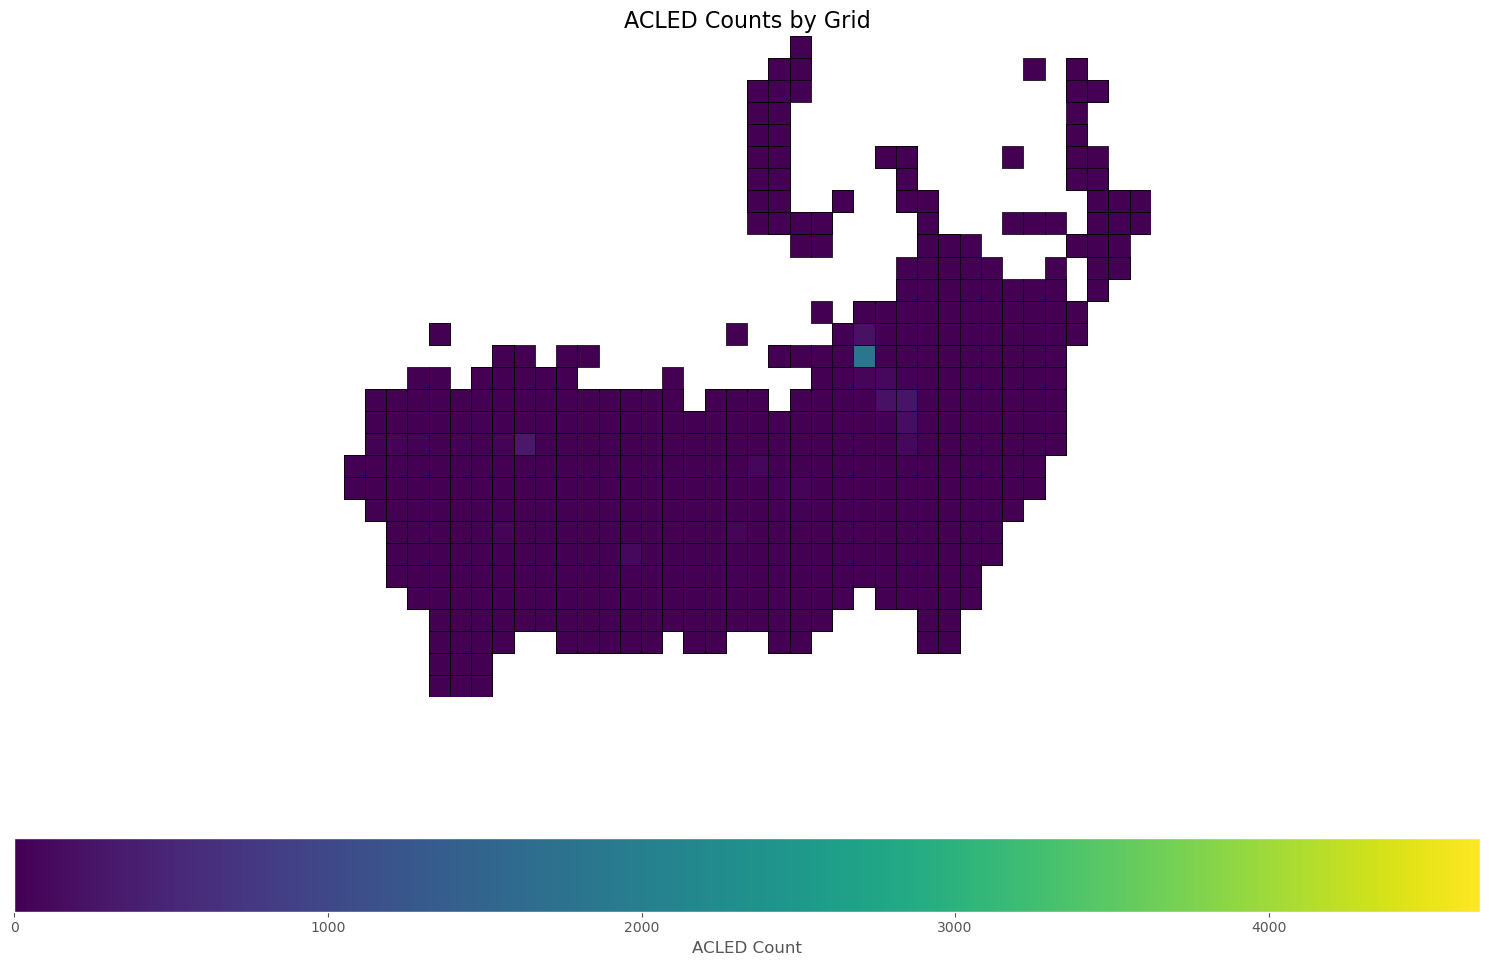

In [58]:
# Check if the GeoDataFrame is empty
if gdf_filter1.empty:
    print("The GeoDataFrame is empty. Please check your data.")
else:
    # Create the plot
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    # Plot the ACLED counts
    gdf_filter1.plot(column='acled_count', 
             ax=ax, 
             legend=True, 
             legend_kwds={'label': 'ACLED Count', 'orientation': 'horizontal'},
             cmap='viridis',  # Changed to viridis colormap
             missing_kwds={'color': 'lightgrey'},
             edgecolor='black',
             linewidth=0.5)
    # Add a title
    plt.title('ACLED Counts by Grid', fontsize=16)
    # Remove axes
    ax.axis('off')
    # Set the extent of the plot to the bounds of the data
    ax.set_xlim(gdf_filter1.total_bounds[0], gdf_filter1.total_bounds[2])
    ax.set_ylim(gdf_filter1.total_bounds[1], gdf_filter1.total_bounds[3])
    # Adjust layout and save
    plt.tight_layout()
    plt.savefig('acled_counts_map_without_zero_fire.png', dpi=300, bbox_inches='tight')
    
    print("ACLED counts map saved as 'acled_counts_map_without_zero_fire.png'")
    # Display the plot (optional - remove if you don't want to display it)
    plt.show()

In [60]:
# Print some information about the GeoDataFrame
print(f"Number of rows: {len(gdf_filter1)}")
print(f"Columns: {gdf_filter1.columns}")
print(f"CRS: {gdf_filter1.crs}")
print(f"Geometry type: {gdf_filter1.geometry.geom_type.value_counts()}")
print(f"Bounding box: {gdf_filter1.total_bounds}")
print(f"ACLED count range: {gdf_filter1['acled_count'].min()} to {gdf_filter1['acled_count'].max()}")

Number of rows: 6947
Columns: Index(['grid_id', 'year', 'fireCount', 'acled_count', 'geometry'], dtype='object')
CRS: EPSG:4326
Geometry type: Polygon    6947
Name: count, dtype: int64
Bounding box: [21.55956682  8.5339952  38.62755722 22.00872446]
ACLED count range: 0 to 4674


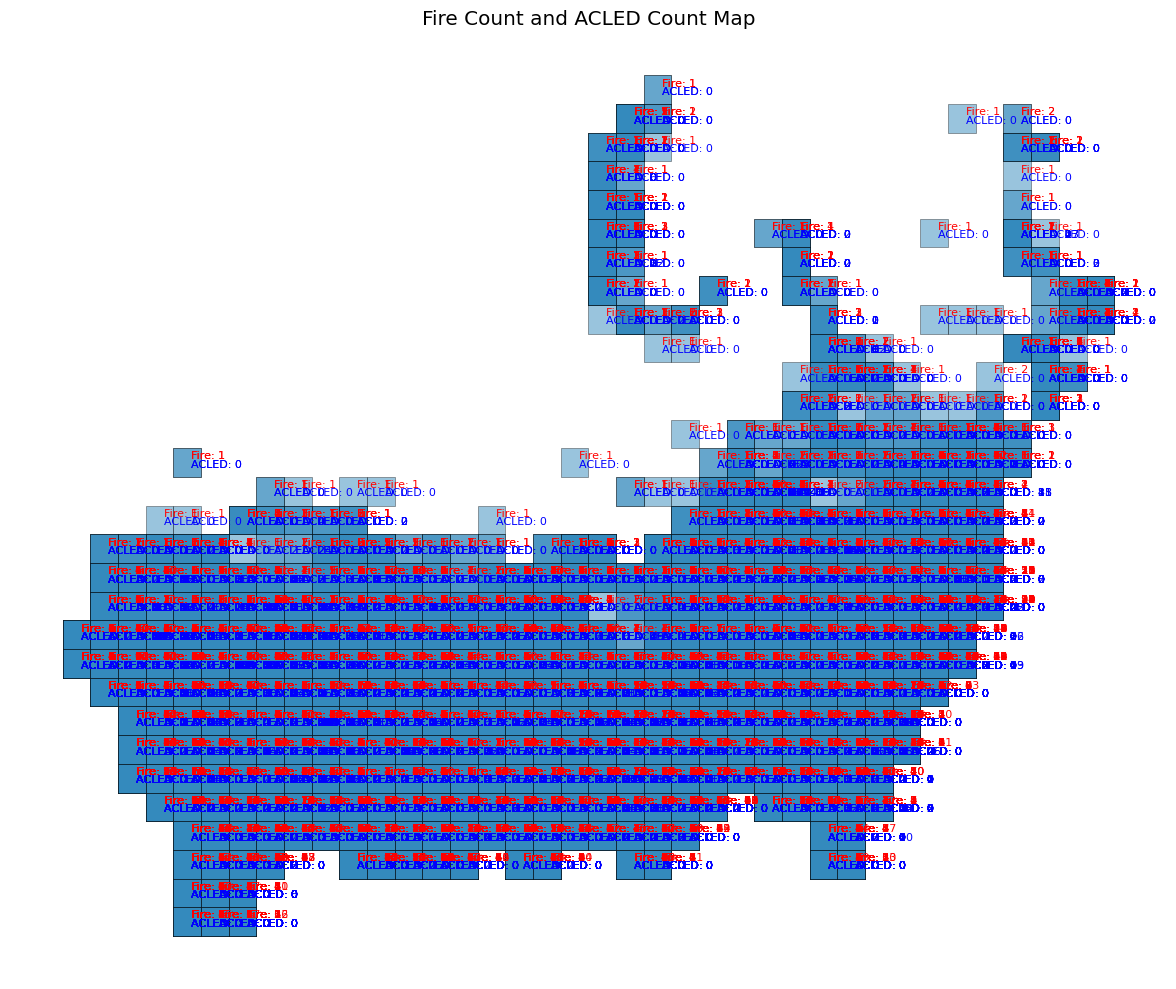

In [66]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(15, 10))

# Plot the geometries
gdf_filter1.plot(ax=ax, edgecolor='black', alpha=0.5)

# Add fire count labels
for idx, row in gdf_filter1.iterrows():
    centroid = row['geometry'].centroid
    ax.annotate(f"Fire: {row['fireCount']}", 
                (centroid.x, centroid.y),
                xytext=(3, 3),
                textcoords="offset points",
                fontsize=8,
                color='red')

# Add ACLED count labels
for idx, row in gdf_filter1.iterrows():
    centroid = row['geometry'].centroid
    ax.annotate(f"ACLED: {row['acled_count']}", 
                (centroid.x, centroid.y),
                xytext=(3, -3),
                textcoords="offset points",
                fontsize=8,
                color='blue')

# Set the title
plt.title('Fire Count and ACLED Count Map')

# Remove axis labels
ax.set_axis_off()

# Show the plot
plt.tight_layout()
plt.show()

# Doing some Regression Analysis

In [92]:
gdf_temp = gdf_new[gdf_new['year'] == 2020]

<Axes: xlabel='fireCount', ylabel='acled_count'>

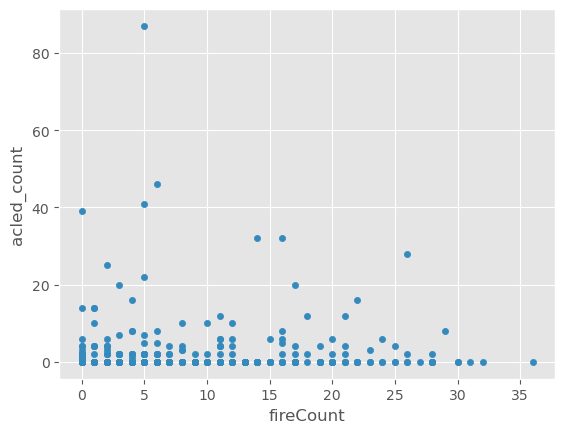

In [93]:
gdf_temp.plot(x = 'fireCount', y= 'acled_count', kind = 'scatter')

In [46]:
# Prepare the data for regression
#X = gdf_filter1['acled_count']  # Independent variable
#y = gdf_filter1['fireCount']    # Dependent variable

X = gdf_new['acled_count']  # Independent variable
y = gdf_new['fireCount']    # Dependent variable

In [51]:
# Add a constant term to the independent variable
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the summary of the regression
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              fireCount   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     11.39
Date:                Thu, 01 Aug 2024   Prob (F-statistic):           0.000741
Time:                        21:05:17   Log-Likelihood:                -58012.
No. Observations:               17850   AIC:                         1.160e+05
Df Residuals:                   17848   BIC:                         1.160e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           3.3228      0.047     71.070      

In [50]:
X.head()

,const,acled_count
0,1.0000,0
1,1.0000,2
2,1.0000,0
3,1.0000,0
4,1.0000,44


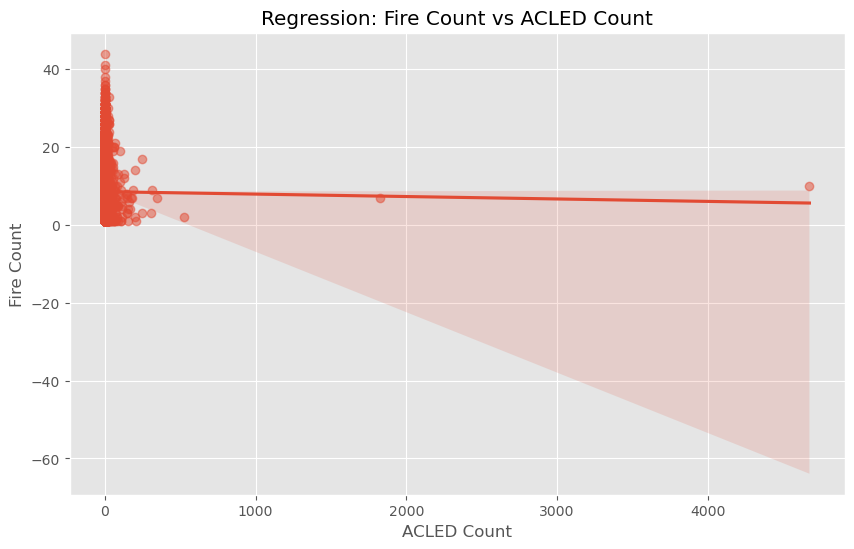

In [52]:
# Create a scatter plot with regression line
plt.figure(figsize=(10, 6))
sns.regplot(x='acled_count', y='fireCount', data=gdf_filter1, scatter_kws={'alpha':0.5})
plt.title('Regression: Fire Count vs ACLED Count')
plt.xlabel('ACLED Count')
plt.ylabel('Fire Count')
plt.show()

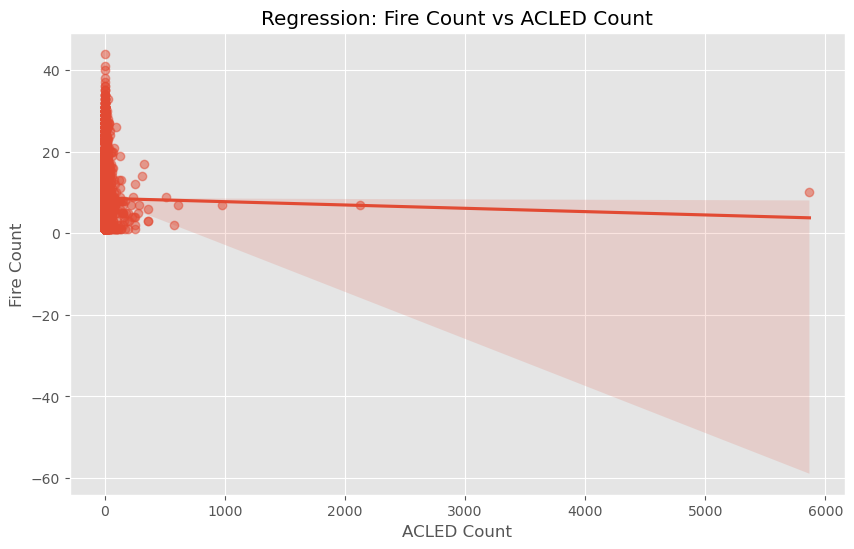

In [49]:
# # Create a scatter plot with regression line
# plt.figure(figsize=(10, 6))
# sns.regplot(x='acled_count', y='fireCount', data=gdf_filter1, scatter_kws={'alpha':0.5})
# plt.title('Regression: Fire Count vs ACLED Count')
# plt.xlabel('ACLED Count')
# plt.ylabel('Fire Count')
# plt.show()

In [50]:
# Print additional statistics
print(f"R-squared: {model.rsquared:.4f}")
print(f"Adjusted R-squared: {model.rsquared_adj:.4f}")
print(f"F-statistic: {model.fvalue:.4f}")
print(f"Prob (F-statistic): {model.f_pvalue:.4f}")

# Print coefficients
print("\nCoefficients:")
print(f"Intercept: {model.params[0]:.4f}")
print(f"ACLED Count: {model.params[1]:.4f}")

# Print p-values
print("\np-values:")
print(f"Intercept: {model.pvalues[0]:.4f}")
print(f"ACLED Count: {model.pvalues[1]:.4f}")

R-squared: 0.0001
Adjusted R-squared: -0.0001
F-statistic: 0.5155
Prob (F-statistic): 0.4728

Coefficients:
Intercept: 8.5596
ACLED Count: -0.0008

p-values:
Intercept: 0.0000
ACLED Count: 0.4728


R-squared: 0.000

This indicates that there is essentially no linear relationship between ACLED count and fire count. The model explains 0% of the variability in fire count.


Adj. R-squared: -0.000

The adjusted R-squared is also effectively zero, confirming the lack of explanatory power.


F-statistic: 0.5155 with Prob (F-statistic): 0.473

This high p-value (> 0.05) suggests that the model is not statistically significant.


Coefficients:

Intercept (const): 8.5596

This is the expected fire count when ACLED count is zero.


acled_count: -0.0008

For each unit increase in ACLED count, the fire count is expected to decrease by 0.0008. However, this is not statistically significant.




P-values:

Intercept: 0.000 (statistically significant)
acled_count: 0.473 (not statistically significant, as it's > 0.05)


Durbin-Watson: 1.052

This value is below 2, suggesting positive autocorrelation in the residuals.


Jarque-Bera (JB) test: 1252.156 with Prob(JB): 1.25e-272

This very low p-value suggests that the residuals are not normally distributed.



Interpretation:

There is no significant linear relationship between ACLED count and fire count.
The model has no explanatory power (R-squared ≈ 0).
The coefficient for ACLED count is not statistically significant (p-value > 0.05).
The residuals show signs of autocorrelation and are not normally distributed, which violates some assumptions of OLS regression.

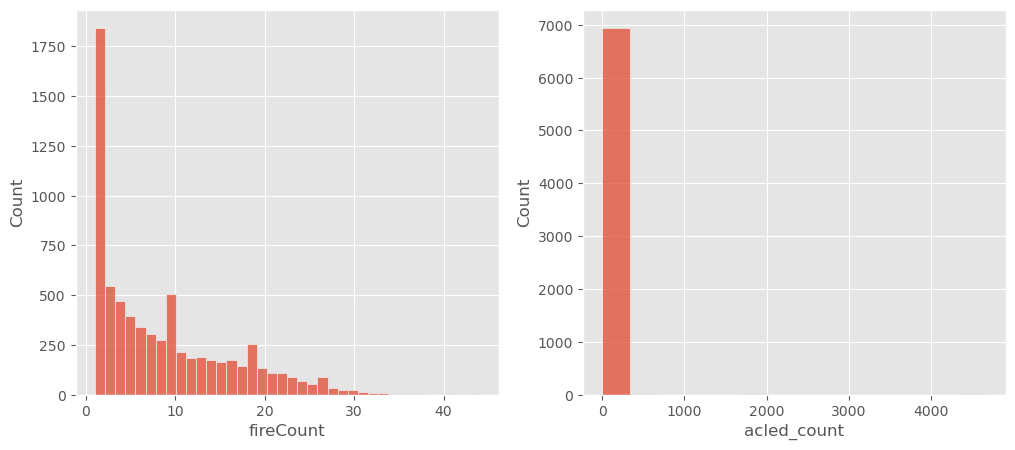

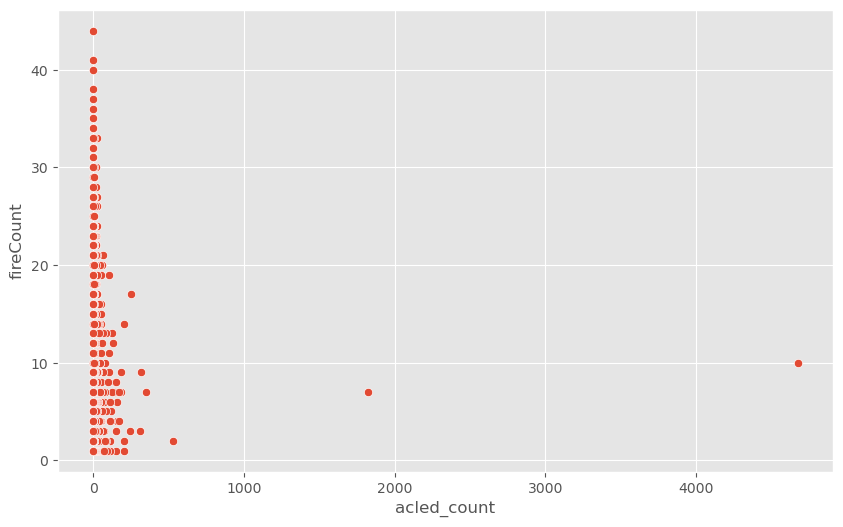

In [61]:
# Histograms
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(gdf_filter1['fireCount'], ax=ax1)
sns.histplot(gdf_filter1['acled_count'], ax=ax2)
plt.show()

# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='acled_count', y='fireCount', data=gdf_filter1)
plt.show()

In [62]:
# We'll use 'fireCount' as the dependent variable and 'acled_count' as the independent variable

# Prepare your data
y = gdf_filter1['fireCount']
X = gdf_filter1[['acled_count']]
X = sm.add_constant(X)  # Add a constant term

# Fit the Poisson Regression model
poisson_model = sm.GLM(y, X, family=sm.families.Poisson())
poisson_results = poisson_model.fit()

# Print the summary of the results
print(poisson_results.summary())

# If you want to make predictions
predictions = poisson_results.predict(X)

# Add predictions to your geodataframe
gdf_predicted = gdf_filter1
gdf_predicted['predicted_fireCount'] = predictions

# Calculate and print pseudo R-squared
null_model = sm.GLM(y, sm.add_constant(np.ones_like(y)), family=sm.families.Poisson()).fit()
pseudo_r2 = 1 - (poisson_results.deviance / null_model.deviance)
print(f"Pseudo R-squared: {pseudo_r2}")

                 Generalized Linear Model Regression Results                  
Dep. Variable:              fireCount   No. Observations:                 6947
Model:                            GLM   Df Residuals:                     6945
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -33930.
Date:                Mon, 29 Jul 2024   Deviance:                       43008.
Time:                        19:14:11   Pearson chi2:                 4.50e+04
No. Iterations:                     5   Pseudo R-squ. (CS):          0.0001965
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           2.1468      0.004    522.198      

In [52]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

X = gdf_filter[['acled_count']]
y = gdf_filter['fireCount']

for degree in [2, 3, 4]:
    poly_features = PolynomialFeatures(degree=degree, include_bias=False)
    X_poly = poly_features.fit_transform(X)
    
    model = LinearRegression()
    model.fit(X_poly, y)
    
    y_pred = model.predict(X_poly)
    r2 = r2_score(y, y_pred)
    
    print(f"Polynomial Regression (degree {degree}) R-squared: {r2:.4f}")

Polynomial Regression (degree 2) R-squared: 0.0008
Polynomial Regression (degree 3) R-squared: 0.0013
Polynomial Regression (degree 4) R-squared: 0.0015


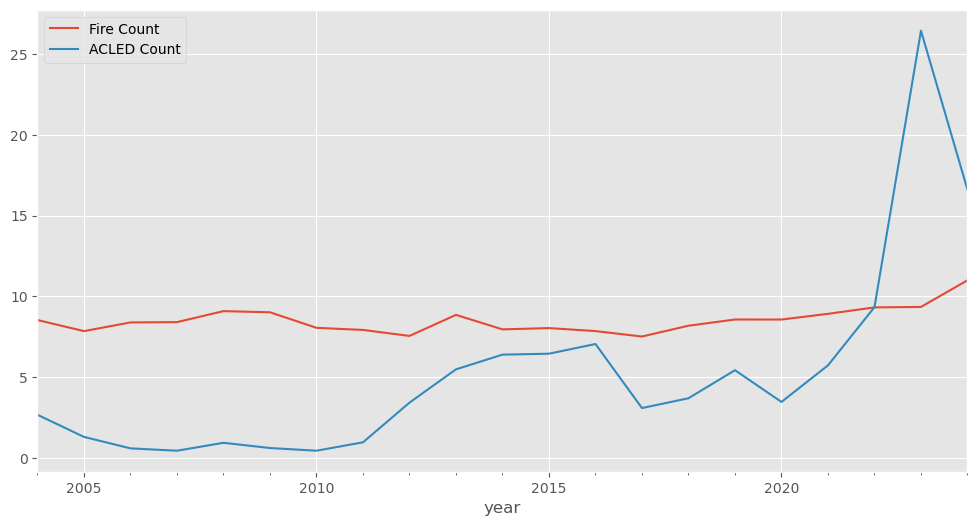

In [53]:
gdf_filter['year'] = pd.to_datetime(gdf_filter['year'], format='%Y')
gdf_filter.set_index('year', inplace=True)

# Time series plot
plt.figure(figsize=(12, 6))
gdf_filter.groupby(gdf_filter.index)['fireCount'].mean().plot()
gdf_filter.groupby(gdf_filter.index)['acled_count'].mean().plot()
plt.legend(['Fire Count', 'ACLED Count'])
plt.show()

Moran's I for fire count: 0.5981
p-value: 0.0010


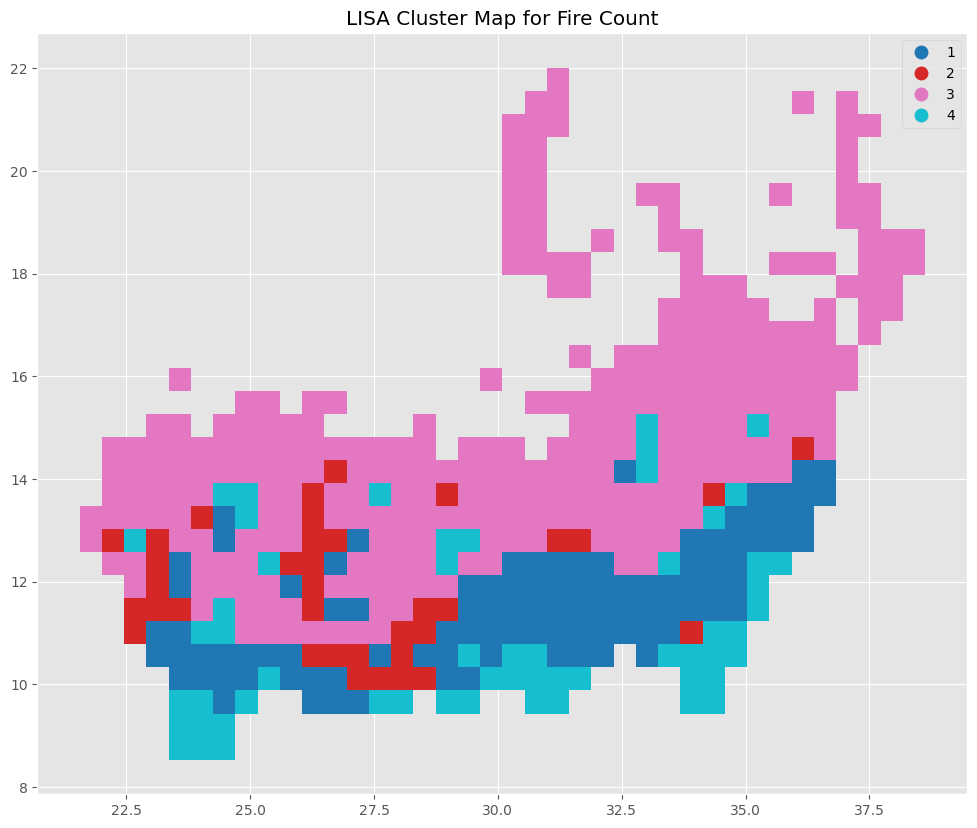

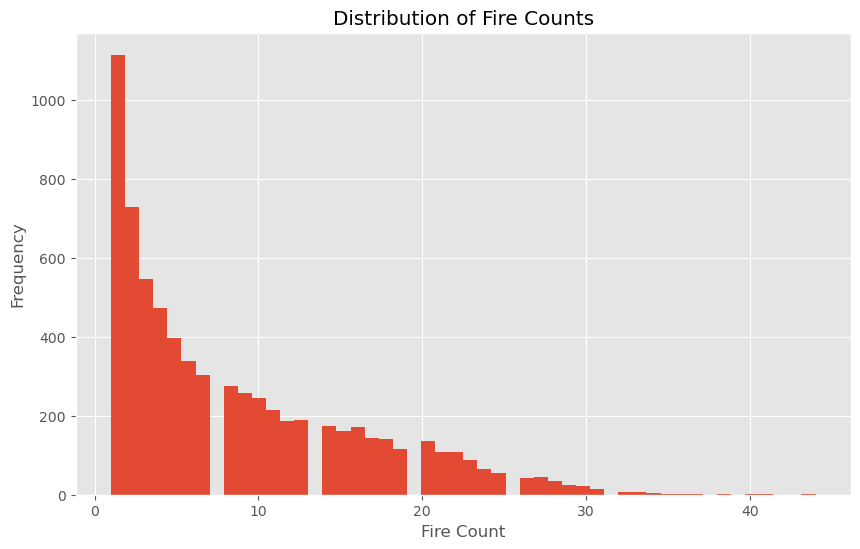

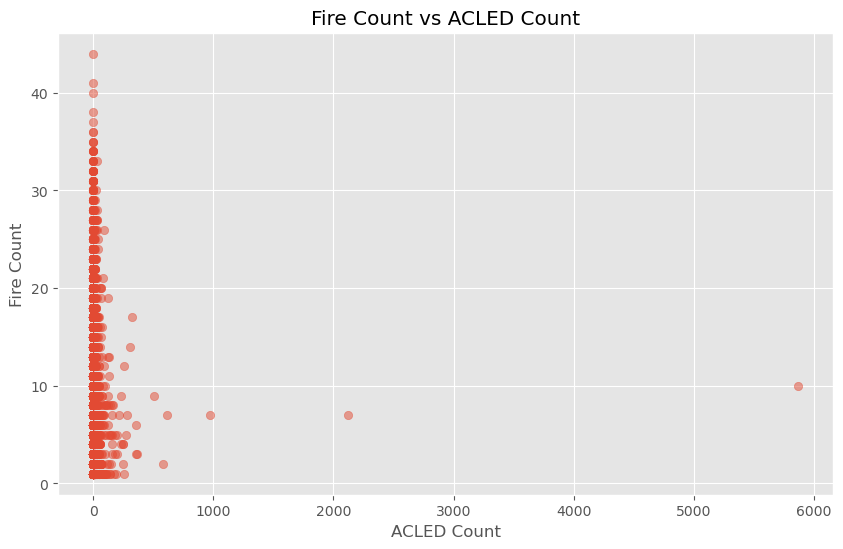


Moran's I for ACLED count: 0.2109
p-value: 0.0010


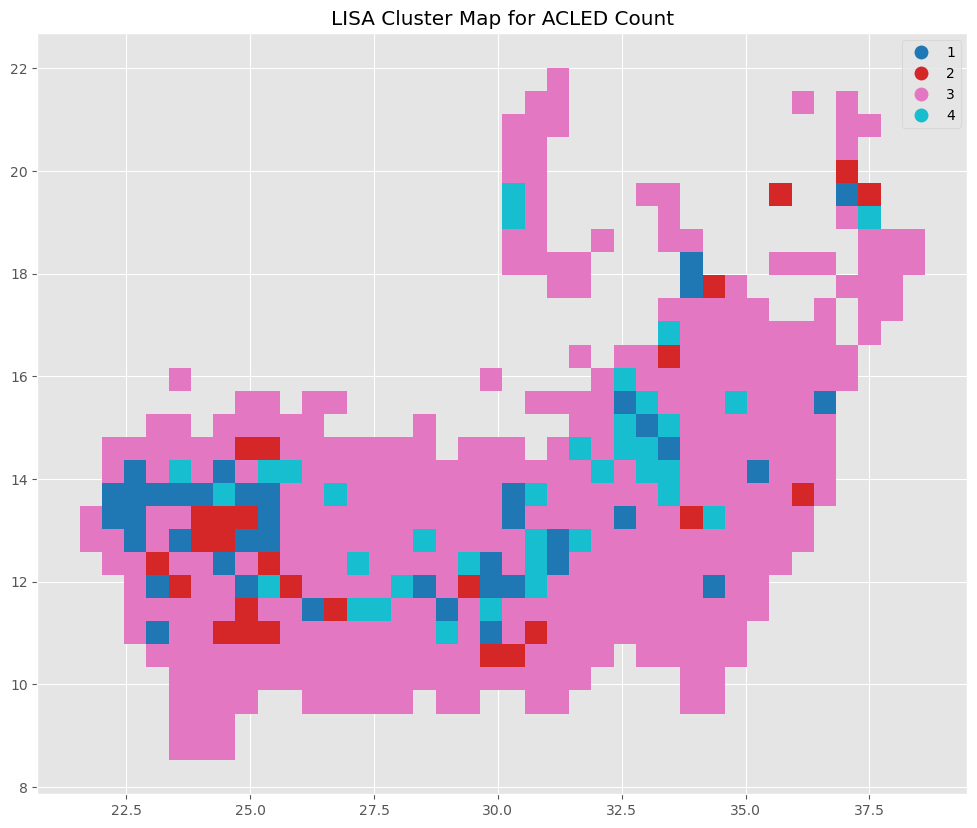

In [55]:
import geopandas as gpd
import matplotlib.pyplot as plt
from pysal.explore import esda
from pysal.lib import weights
import numpy as np

# First, let's reset the index of your GeoDataFrame to ensure consecutive integers
gdf_filter = gdf_filter.reset_index(drop=True)

# Now, let's create the spatial weights matrix
w = weights.distance.KNN.from_dataframe(gdf_filter, k=5)

# Calculate Moran's I for fire count
moran = esda.Moran(gdf_filter['fireCount'], w)
print(f"Moran's I for fire count: {moran.I:.4f}")
print(f"p-value: {moran.p_sim:.4f}")

# Local Indicators of Spatial Association (LISA)
lisa = esda.Moran_Local(gdf_filter['fireCount'], w)

# Plot LISA cluster map
gdf_filter['lisa_cluster'] = lisa.q
fig, ax = plt.subplots(figsize=(12, 10))
gdf_filter.plot(column='lisa_cluster', categorical=True, legend=True, ax=ax)
ax.set_title('LISA Cluster Map for Fire Count')
plt.show()

# Let's also look at the distribution of fire counts
plt.figure(figsize=(10, 6))
gdf_filter['fireCount'].hist(bins=50)
plt.title('Distribution of Fire Counts')
plt.xlabel('Fire Count')
plt.ylabel('Frequency')
plt.show()

# And the relationship between fire count and ACLED count
plt.figure(figsize=(10, 6))
plt.scatter(gdf_filter['acled_count'], gdf_filter['fireCount'], alpha=0.5)
plt.title('Fire Count vs ACLED Count')
plt.xlabel('ACLED Count')
plt.ylabel('Fire Count')
plt.show()

# Let's also check for any spatial patterns in ACLED count
moran_acled = esda.Moran(gdf_filter['acled_count'], w)
print(f"\nMoran's I for ACLED count: {moran_acled.I:.4f}")
print(f"p-value: {moran_acled.p_sim:.4f}")

# And create a LISA cluster map for ACLED count
lisa_acled = esda.Moran_Local(gdf_filter['acled_count'], w)
gdf_filter['lisa_cluster_acled'] = lisa_acled.q
fig, ax = plt.subplots(figsize=(12, 10))
gdf_filter.plot(column='lisa_cluster_acled', categorical=True, legend=True, ax=ax)
ax.set_title('LISA Cluster Map for ACLED Count')
plt.show()

# Adding event_id for Sudan to Acled Data

In [4]:
acled_event_id = pd.read_csv("data/acled_data_with_event_ids/ACLED_2004_Counts_1.csv", encoding="latin1")

In [5]:
acled_event_id

,system:index,acled_count,acled_event_ids,grid_id,year,.geo
0,"52,19",0,[],"52,19",2004,"{""geodesic"":false,""crs"":{""type"":""name"",""proper..."
1,"53,19",0,[],"53,19",2004,"{""geodesic"":false,""crs"":{""type"":""name"",""proper..."
2,"54,19",0,[],"54,19",2004,"{""geodesic"":false,""crs"":{""type"":""name"",""proper..."
3,"52,20",0,[],"52,20",2004,"{""geodesic"":false,""crs"":{""type"":""name"",""proper..."
4,"53,20",0,[],"53,20",2004,"{""geodesic"":false,""crs"":{""type"":""name"",""proper..."
...,...,...,...,...,...,...
845,"70,49",0,[],"70,49",2004,"{""geodesic"":false,""crs"":{""type"":""name"",""proper..."
846,"79,49",0,[],"79,49",2004,"{""geodesic"":false,""crs"":{""type"":""name"",""proper..."
847,"80,49",0,[],"80,49",2004,"{""geodesic"":false,""crs"":{""type"":""name"",""proper..."
848,"81,49",0,[],"81,49",2004,"{""geodesic"":false,""crs"":{""type"":""name"",""proper..."


In [6]:
acled_event_id.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   system:index     850 non-null    object
 1   acled_count      850 non-null    int64 
 2   acled_event_ids  850 non-null    object
 3   grid_id          850 non-null    object
 4   year             850 non-null    int64 
 5   .geo             850 non-null    object
dtypes: int64(2), object(4)
memory usage: 40.0+ KB


In [8]:
# Filter the DataFrame for the specific grid_id "54,20"
specific_grid_id_df = acled_event_id[acled_event_id['grid_id'] == "54,20"]

# Display the rows corresponding to the grid_id "54,20"
print(specific_grid_id_df)

  system:index  acled_count  \
5        54,20            8   

                                     acled_event_ids grid_id  year  \
5  [SUD2108, SUD2108, SUD2013, SUD2013, SUD2010, ...   54,20  2004   

                                                .geo  
5  {"geodesic":false,"crs":{"type":"name","proper...  


In [7]:
# Assuming your DataFrame is named 'df'
df = acled_event_id[acled_event_id['acled_count'] != 0]

In [8]:
df

,system:index,acled_count,acled_event_ids,grid_id,year,.geo
5,"54,20",8,"[SUD2108, SUD2108, SUD2013, SUD2013, SUD2010, ...","54,20",2004,"{""geodesic"":false,""crs"":{""type"":""name"",""proper..."
46,"55,23",22,"[SUD2306, SUD2306, SUD2301, SUD2301, SUD2299, ...","55,23",2004,"{""geodesic"":false,""crs"":{""type"":""name"",""proper..."
72,"54,24",12,"[SUD2035, SUD2035, SUD2115, SUD2115, SUD2279, ...","54,24",2004,"{""geodesic"":false,""crs"":{""type"":""name"",""proper..."
73,"55,24",16,"[SUD2292, SUD2292, SUD2288, SUD2288, SUD2284, ...","55,24",2004,"{""geodesic"":false,""crs"":{""type"":""name"",""proper..."
74,"56,24",18,"[SUD1963, SUD1963, SUD1897, SUD1897, SUD1875, ...","56,24",2004,"{""geodesic"":false,""crs"":{""type"":""name"",""proper..."
80,"62,24",6,"[SUD2097, SUD2097, SUD2092, SUD2092, SUD2084, ...","62,24",2004,"{""geodesic"":false,""crs"":{""type"":""name"",""proper..."
99,"53,25",2,"[SUD1997, SUD1997]","53,25",2004,"{""geodesic"":false,""crs"":{""type"":""name"",""proper..."
100,"54,25",4,"[SUD1914, SUD1914, SUD2050, SUD2050]","54,25",2004,"{""geodesic"":false,""crs"":{""type"":""name"",""proper..."
101,"55,25",6,"[SUD2045, SUD2045, SUD1923, SUD1923, SUD2042, ...","55,25",2004,"{""geodesic"":false,""crs"":{""type"":""name"",""proper..."
102,"56,25",4,"[SUD2114, SUD2114, SUD2043, SUD2043]","56,25",2004,"{""geodesic"":false,""crs"":{""type"":""name"",""proper..."


In [9]:
# Create a new DataFrame with columns `year`, `grid_id`, and `acled_event_ids`
new_df = df[['year', 'grid_id', 'acled_event_ids']]

In [10]:
new_df

,year,grid_id,acled_event_ids
5,2004,"54,20","[SUD2108, SUD2108, SUD2013, SUD2013, SUD2010, ..."
46,2004,"55,23","[SUD2306, SUD2306, SUD2301, SUD2301, SUD2299, ..."
72,2004,"54,24","[SUD2035, SUD2035, SUD2115, SUD2115, SUD2279, ..."
73,2004,"55,24","[SUD2292, SUD2292, SUD2288, SUD2288, SUD2284, ..."
74,2004,"56,24","[SUD1963, SUD1963, SUD1897, SUD1897, SUD1875, ..."
80,2004,"62,24","[SUD2097, SUD2097, SUD2092, SUD2092, SUD2084, ..."
99,2004,"53,25","[SUD1997, SUD1997]"
100,2004,"54,25","[SUD1914, SUD1914, SUD2050, SUD2050]"
101,2004,"55,25","[SUD2045, SUD2045, SUD1923, SUD1923, SUD2042, ..."
102,2004,"56,25","[SUD2114, SUD2114, SUD2043, SUD2043]"


In [110]:
acled_event_id['acled_event_ids']

0      []
1      []
2      []
3      []
4      []
       ..
845    []
846    []
847    []
848    []
849    []
Name: acled_event_ids, Length: 850, dtype: object

In [15]:
# # Checking for non-empty acled_event_ids
# non_empty_acled_event_ids = acled_event_id[acled_event_id['acled_event_ids'].apply(lambda x: len(x) > 0)]
# print(non_empty_acled_event_ids)

In [16]:
# import ast

# def parse_list(s):
#     try:
#         return ast.literal_eval(s)
#     except:
#         return []

# df = pd.read_csv('data/acled_data_with_event_ids/ACLED_2004_Counts_1.csv')
# df['acled_event_ids'] = df['acled_event_ids'].apply(parse_list)

In [126]:
import pandas as pd
import ast

def parse_list(s):
    try:
        return ast.literal_eval(s)
    except:
        return []

# Read the CSV file
df1 = pd.read_csv('data/acled_data_with_event_ids/ACLED_2004_Counts_1.csv', sep='\t')

# Print the column names
print("Columns in the DataFrame:")
print(df1.columns)

# Print the first few rows
print("\nFirst few rows of the DataFrame:")
print(df1.head())

# If 'acled_event_ids' is not in the columns, let's check if it's named differently
possible_event_id_columns = [col for col in df1.columns if 'event' in col.lower()]
if possible_event_id_columns:
    print("\nPossible columns containing event IDs:")
    print(possible_event_id_columns)

# If we find a column that looks like it contains event IDs, let's try to parse it
if possible_event_id_columns:
    column_to_parse = possible_event_id_columns[0]
    df1[column_to_parse] = df1[column_to_parse].apply(parse_list)
    print(f"\nFirst few entries of the '{column_to_parse}' column after parsing:")
    print(df1[column_to_parse].head())

Columns in the DataFrame:
Index(['system:index,acled_count,acled_event_ids,grid_id,year,.geo'], dtype='object')

First few rows of the DataFrame:
  system:index,acled_count,acled_event_ids,grid_id,year,.geo
0  52,19,0,[],"52,19",2004,"{""geodesic"":false,"...        
1  53,19,0,[],"53,19",2004,"{""geodesic"":false,"...        
2  54,19,0,[],"54,19",2004,"{""geodesic"":false,"...        
3  52,20,0,[],"52,20",2004,"{""geodesic"":false,"...        
4  53,20,0,[],"53,20",2004,"{""geodesic"":false,"...        

Possible columns containing event IDs:
['system:index,acled_count,acled_event_ids,grid_id,year,.geo']

First few entries of the 'system:index,acled_count,acled_event_ids,grid_id,year,.geo' column after parsing:
0    (52, 19, 0, [], 52,19, 2004, {geodesic:false,c...
1    (53, 19, 0, [], 53,19, 2004, {geodesic:false,c...
2    (54, 19, 0, [], 54,19, 2004, {geodesic:false,c...
3    (52, 20, 0, [], 52,20, 2004, {geodesic:false,c...
4    (53, 20, 0, [], 53,20, 2004, {geodesic:false,c...
N

In [17]:
# import pandas as pd
# import ast
# import io

# def parse_list(s):
#     try:
#         return ast.literal_eval(s)
#     except:
#         return []

# # Read the CSV file
# with open('data/acled_data_with_event_ids/ACLED_2004_Counts_1.csv', 'r') as file:
#     content = file.read()

# # Replace the problematic commas within the .geo field
# content = content.replace('"{', '{{').replace('}"', '}}')

# # Now read the modified content
# df1 = pd.read_csv(io.StringIO(content), sep=',')

# # Print the column names
# print("Columns in the DataFrame:")
# print(df1.columns)

# # Print the first few rows
# print("\nFirst few rows of the DataFrame:")
# print(df1.head())

# # Parse the acled_event_ids column
# df1['acled_event_ids'] = df1['acled_event_ids'].apply(parse_list)

# print("\nFirst few entries of the 'acled_event_ids' column after parsing:")
# print(df1['acled_event_ids'].head())

# # Parse the .geo column
# df1['.geo'] = df1['.geo'].apply(lambda x: x.replace('{{', '{').replace('}}', '}'))
# df1['.geo'] = df1['.geo'].apply(ast.literal_eval)

# print("\nFirst few entries of the '.geo' column after parsing:")
# print(df1['.geo'].head())

In [18]:
# # import pandas as pd
# # import ast

# # def parse_list(s):
# #     try:
# #         return ast.literal_eval(s)
# #     except:
# #         return []

# # # Read the CSV file (assuming it's correctly read now)
# # df1 = pd.read_csv('data/acled_data_with_event_ids/ACLED_2004_Counts_1.csv', sep=',')

# # # Parse the acled_event_ids column
# # df1['acled_event_ids'] = df1['acled_event_ids'].apply(parse_list)

# # Check for non-empty lists
# non_empty = df1[df1['acled_event_ids'].apply(len) > 0]

# print(f"Number of rows with non-empty acled_event_ids: {len(non_empty)}")

# if len(non_empty) > 0:
#     print("\nSample rows with non-empty acled_event_ids:")
#     print(non_empty[['grid_id', 'acled_count', 'acled_event_ids']].head())
# else:
#     print("\nNo rows found with non-empty acled_event_ids.")

# # Additional check: distribution of list lengths
# length_distribution = df1['acled_event_ids'].apply(len).value_counts().sort_index()
# print("\nDistribution of acled_event_ids list lengths:")
# print(length_distribution)

# # Check for any lists with length not equal to acled_count
# mismatched = df1[df1['acled_event_ids'].apply(len) != df1['acled_count']]
# print(f"\nNumber of rows where length of acled_event_ids doesn't match acled_count: {len(mismatched)}")

# if len(mismatched) > 0:
#     print("\nSample mismatched rows:")
#     print(mismatched[['grid_id', 'acled_count', 'acled_event_ids']].head())